<h1>Project 3</h1>


In [1]:
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

tqdm.pandas()

<h2>Import dataset</h2>

In [2]:
data = pd.read_csv('project3_data.csv')

<h2> Explore the data</h2>

In [3]:
data

,flags,utterance,category,intent
0,BILC,"I don't have an online account, what do I have...",ACCOUNT,create_account
1,BILQZ,can you tell me if i can regisger two accounts...,ACCOUNT,create_account
2,BPLC,"I have no online account, open one, please",ACCOUNT,create_account
3,BIPLD,"could you ask an agent how to open an account,...",ACCOUNT,create_account
4,BLQC,"i want an online account, create one",ACCOUNT,create_account
...,...,...,...,...
21493,BILQC,"i have no shipping address, what do i have to ...",SHIPPING,set_up_shipping_address
21494,BLQC,I have no shipping address and I want to set o...,SHIPPING,set_up_shipping_address
21495,BIQC,"i want to set up my shipping address, what do ...",SHIPPING,set_up_shipping_address
21496,BILC,"I don't have a shipping address, can you set o...",SHIPPING,set_up_shipping_address


In [4]:
data['category'].value_counts()

PAYMENT             4636
ACCOUNT             4557
CONTACT             3081
INVOICES            2443
ORDER               2220
REFUNDS             1932
FEEDBACK            1326
DELIVERY             501
CANCELLATION_FEE     360
NEWSLETTER           236
SHIPPING             206
Name: category, dtype: int64

In [5]:
data['intent'].value_counts()

payment_issue               4366
create_account              2122
contact_customer_service    2055
get_invoice                 1430
track_order                 1224
get_refund                  1150
contact_human_agent         1026
check_invoices              1013
recover_password             986
change_order                 926
delete_account               913
complaint                    746
review                       580
check_refund_policy          479
check_cancellation_fee       360
delivery_options             360
track_refund                 303
switch_account               273
check_payment_methods        270
newsletter_subscription      236
delivery_period              141
edit_account                 133
registration_problems        130
change_shipping_address      110
set_up_shipping_address       96
place_order                   70
Name: intent, dtype: int64

<AxesSubplot:title={'center':'Intent Groupings vs Number of Utterances'}>

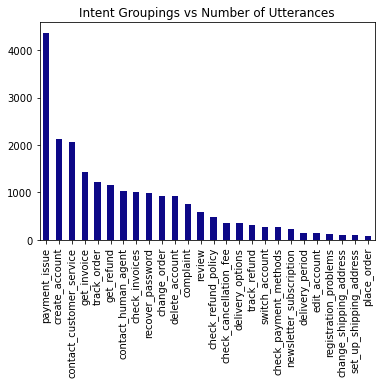

In [6]:
data['intent'].value_counts().plot(kind='bar', title='Intent Groupings vs Number of Utterances', cmap='plasma')

<br>
The bar chart above shows that our dataset is imbalanced since the number of observations per class is not equally distributed. For example, the number of utterances belonging to "payment_issue" is more than 121 times of "cancel_order" utterances.

In [7]:
# Create a dataframe that contains number of words for each document 
dlength_data = pd.DataFrame({'doc_length': data.utterance.apply(lambda x: len(x.split()))})

In [8]:
# Group the documents based on their number of words (i.e. length)
grouped = dlength_data.groupby('doc_length')

indices = grouped.indices
word_count = []
doc_count = []
counter = 0
for w,d in indices.items():
    word_count.append(w)
    doc_count.append(len(d))

Text(0.5, 1.0, 'Word count vs Number of documents')

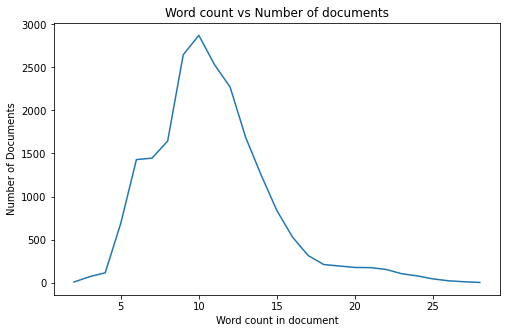

In [9]:
# Plot the distribution of words vs documents in the corpus
plt.figure(figsize=(8,5))
plt.plot(word_count, doc_count)
plt.xlabel('Word count in document')
plt.ylabel('Number of Documents')
plt.title('Word count vs Number of documents')

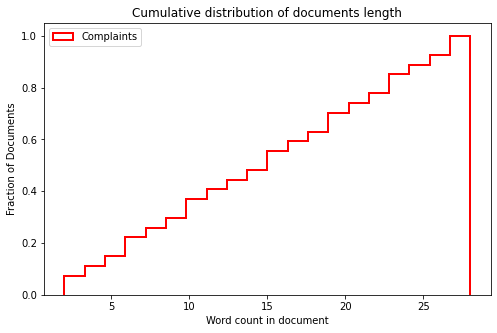

In [10]:
# Plot the Cumulative distribution of documents length
plt.figure(figsize=(8,5))
plt.hist(word_count, 20, density=True, histtype='step', cumulative=True, label='Complaints', color='red', linewidth=2)
plt.xlabel('Word count in document')
plt.ylabel('Fraction of Documents')
plt.legend(loc='upper left')
plt.title('Cumulative distribution of documents length')
plt.show()

By looking at the charts above, we realize that most utterances fall between 5-15 words. Also, the fraction of documents with less than 5 words is less than 1%

<h2>Text Preprocessing</h2>

In [11]:
import spacy

nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)


def tokenize(text):
    doc = nlp.tokenizer(text)
    return [t.norm_ for t in doc if t.is_alpha]

In [12]:
import multiprocessing as mp

In [13]:
with mp.Pool() as p:
    data["tokens"] = list(p.imap(tokenize, tqdm(data["utterance"]), chunksize=100))

  0%|          | 0/21498 [00:00<?, ?it/s]

<h3>Split the data into 80% train and 20% test</h3>

In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=25)

In [15]:
train.head()

,flags,utterance,category,intent,tokens
7369,BILCZ,"you aren't helpinmg, can I talk to a human?",CONTACT,contact_human_agent,"[you, are, helpinmg, can, i, talk, to, a, human]"
16953,BIPMQDW,"please, can u ask an agent if i can report fuc...",PAYMENT,payment_issue,"[please, can, u, ask, an, agent, if, i, can, r..."
4750,BIMLCZ,"I want to view cancellation fees , what can I do?",CANCELLATION_FEE,check_cancellation_fee,"[i, want, to, view, cancelation, fees, what, c..."
3656,BSLC,"my account's been hacked, and I need help gett...",ACCOUNT,recover_password,"[my, account, been, hacked, and, i, need, help..."
11951,B,where to get an invoice,INVOICES,get_invoice,"[where, to, get, an, invoice]"


In [16]:
test.head()

,flags,utterance,category,intent,tokens
6590,BILQC,"I want information, what do I have to do to ca...",CONTACT,contact_customer_service,"[i, want, information, what, do, i, have, to, ..."
3774,BILC,"my user account's been hacked, what should i do?",ACCOUNT,recover_password,"[my, user, account, been, hacked, what, should..."
3255,BILC,"my profile's been hacked, how do I recover it?",ACCOUNT,recover_password,"[my, profile, been, hacked, how, do, i, recove..."
19017,BILQC,i get an error message when i try to make a pa...,PAYMENT,payment_issue,"[i, get, an, error, message, when, i, try, to,..."
16416,BIML,where do I inform of problems making a payment?,PAYMENT,payment_issue,"[where, do, i, inform, of, problems, making, a..."


<h2>Modeling</h2>

In [17]:
import mlflow
mlflow.sklearn.autolog(silent=True)

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.pipeline import make_pipeline

<h2>Naive Bayes</h2>
<h3> (MultinomialNB baseline)</h3>

In [18]:
from sklearn.naive_bayes import MultinomialNB

In [19]:
%%time

nb = make_pipeline(CountVectorizer(analyzer=identity), MultinomialNB())
nb.fit(train["tokens"], train["intent"])

/opt/jupyterlab/singleuser/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CPU times: user 2.51 s, sys: 129 ms, total: 2.64 s
Wall time: 5.31 s


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(analyzer=<cyfunction identity at 0x2af611ded450>)),
                ('multinomialnb', MultinomialNB())])

In [20]:
print(classification_report(test["intent"], nb.predict(test["tokens"]), digits=4))

                          precision    recall  f1-score   support

            change_order     0.9507    0.9897    0.9698       195
 change_shipping_address     1.0000    0.9130    0.9545        23
  check_cancellation_fee     1.0000    1.0000    1.0000        67
          check_invoices     0.9894    0.9894    0.9894       188
   check_payment_methods     1.0000    0.9592    0.9792        49
     check_refund_policy     1.0000    0.9889    0.9944        90
               complaint     0.9935    1.0000    0.9967       152
contact_customer_service     0.9977    1.0000    0.9989       442
     contact_human_agent     1.0000    0.9727    0.9861       183
          create_account     0.9933    0.9955    0.9944       444
          delete_account     0.9883    1.0000    0.9941       169
        delivery_options     0.9459    1.0000    0.9722        70
         delivery_period     0.8857    0.8857    0.8857        35
            edit_account     1.0000    0.9474    0.9730        19
         

/opt/jupyterlab/singleuser/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterlab/singleuser/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterlab/singleuser/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
with mlflow.start_run():
    mlflow.sklearn.eval_and_log_metrics(nb, test["tokens"], test["intent"], prefix='test_')

/opt/jupyterlab/singleuser/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/jupyterlab/singleuser/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.distributions import loguniform, randint, uniform

In [23]:
%%time

search = RandomizedSearchCV(
    nb,
    {
        "multinomialnb__alpha": loguniform(1e-4, 1.0),
    },
    n_iter=30,
    n_jobs=-1,
    scoring="f1_macro",
)

with mlflow.start_run():
    search.fit(train["tokens"], train["intent"])

CPU times: user 8.13 s, sys: 528 ms, total: 8.66 s
Wall time: 20.2 s


In [24]:
nb.set_params(multinomialnb__alpha=0.2)
nb.fit(train["tokens"], train["intent"])

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(analyzer=<cyfunction identity at 0x2af611ded450>)),
                ('multinomialnb', MultinomialNB(alpha=0.2))])

In [25]:
print(classification_report(test["intent"], nb.predict(test["tokens"]), digits=4))

                          precision    recall  f1-score   support

            change_order     0.9698    0.9897    0.9797       195
 change_shipping_address     1.0000    1.0000    1.0000        23
  check_cancellation_fee     1.0000    1.0000    1.0000        67
          check_invoices     0.9947    0.9947    0.9947       188
   check_payment_methods     1.0000    1.0000    1.0000        49
     check_refund_policy     1.0000    0.9889    0.9944        90
               complaint     1.0000    1.0000    1.0000       152
contact_customer_service     0.9977    1.0000    0.9989       442
     contact_human_agent     1.0000    0.9945    0.9973       183
          create_account     1.0000    0.9932    0.9966       444
          delete_account     0.9883    1.0000    0.9941       169
        delivery_options     1.0000    1.0000    1.0000        70
         delivery_period     0.9211    1.0000    0.9589        35
            edit_account     1.0000    1.0000    1.0000        19
         

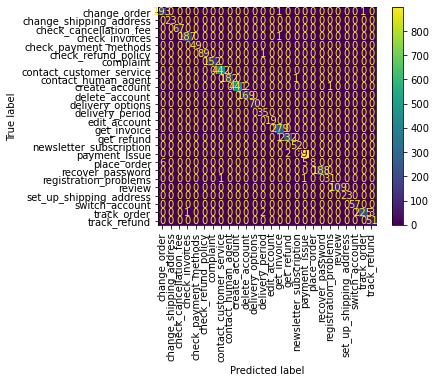

In [26]:
ConfusionMatrixDisplay.from_estimator(nb, test["tokens"], test["intent"], xticks_rotation=90)

<h1>Decision Tree</h1>

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
baseline = make_pipeline(CountVectorizer(analyzer=identity), DecisionTreeClassifier())
with mlflow.start_run():
    baseline.fit(train["tokens"], train["intent"])

In [29]:
tree = baseline.predict(test["tokens"])
print(classification_report(test["intent"], tree))

                          precision    recall  f1-score   support

            change_order       0.98      0.99      0.99       195
 change_shipping_address       1.00      1.00      1.00        23
  check_cancellation_fee       1.00      0.96      0.98        67
          check_invoices       0.99      0.98      0.99       188
   check_payment_methods       0.98      1.00      0.99        49
     check_refund_policy       1.00      1.00      1.00        90
               complaint       1.00      1.00      1.00       152
contact_customer_service       1.00      0.99      1.00       442
     contact_human_agent       0.98      0.99      0.99       183
          create_account       0.98      0.99      0.98       444
          delete_account       1.00      0.98      0.99       169
        delivery_options       1.00      0.97      0.99        70
         delivery_period       0.94      0.94      0.94        35
            edit_account       0.90      1.00      0.95        19
         

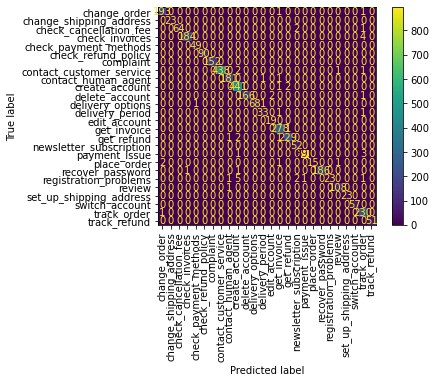

In [30]:
ConfusionMatrixDisplay.from_estimator(baseline, test["tokens"], test["intent"], xticks_rotation=90)

<h3> SGDClassifier baseline</h3>

In [31]:
from sklearn.linear_model import SGDClassifier

In [32]:
baseline = make_pipeline(CountVectorizer(analyzer=identity), SGDClassifier())
with mlflow.start_run():
    baseline.fit(train["tokens"], train["intent"])

In [33]:
base_predicted = baseline.predict(test["tokens"])
print(classification_report(test["intent"], base_predicted))

                          precision    recall  f1-score   support

            change_order       1.00      0.99      0.99       195
 change_shipping_address       1.00      1.00      1.00        23
  check_cancellation_fee       1.00      1.00      1.00        67
          check_invoices       0.99      0.99      0.99       188
   check_payment_methods       1.00      0.98      0.99        49
     check_refund_policy       1.00      1.00      1.00        90
               complaint       1.00      0.99      1.00       152
contact_customer_service       1.00      1.00      1.00       442
     contact_human_agent       0.99      1.00      0.99       183
          create_account       1.00      1.00      1.00       444
          delete_account       1.00      1.00      1.00       169
        delivery_options       0.99      0.99      0.99        70
         delivery_period       0.97      0.97      0.97        35
            edit_account       1.00      1.00      1.00        19
         

In [34]:
mlflow.end_run()

In [35]:
with mlflow.start_run():
    mlflow.sklearn.eval_and_log_metrics(baseline, test["tokens"], test["intent"], prefix='test_')

/opt/jupyterlab/singleuser/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


In [36]:
sgd = make_pipeline(CountVectorizer(analyzer=identity), TfidfTransformer(), SGDClassifier())

In [37]:
%%time

search = RandomizedSearchCV(
    sgd,
    {
        "countvectorizer__min_df": randint(1, 5),
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "tfidftransformer__use_idf": [True, False],
        "sgdclassifier__alpha": loguniform(1e-8, 1e-4),
    },
    n_iter=10,
    n_jobs=-1,
    scoring="f1_macro",
)

with mlflow.start_run():
    search.fit(train["tokens"], train["intent"])

CPU times: user 4.47 s, sys: 431 ms, total: 4.9 s
Wall time: 18.8 s


In [38]:
search.best_score_, search.best_params_

(0.9916271555555006,
 {'countvectorizer__max_df': 0.6105430771903004,
  'countvectorizer__min_df': 4,
  'sgdclassifier__alpha': 9.219851809236589e-07,
  'tfidftransformer__use_idf': True})

In [39]:
sgd.set_params(**search.best_params_)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(analyzer=<cyfunction identity at 0x2af611ded450>,
                                 max_df=0.6105430771903004, min_df=4)),
                ('tfidftransformer', TfidfTransformer()),
                ('sgdclassifier', SGDClassifier(alpha=9.219851809236589e-07))])

In [40]:
with mlflow.start_run():
    sgd.fit(train["tokens"], train["intent"])

In [41]:
predicted = sgd.predict(test["tokens"])
print(classification_report(test["intent"], predicted))

                          precision    recall  f1-score   support

            change_order       0.99      0.99      0.99       195
 change_shipping_address       1.00      1.00      1.00        23
  check_cancellation_fee       1.00      1.00      1.00        67
          check_invoices       0.99      0.99      0.99       188
   check_payment_methods       1.00      1.00      1.00        49
     check_refund_policy       1.00      1.00      1.00        90
               complaint       1.00      1.00      1.00       152
contact_customer_service       1.00      1.00      1.00       442
     contact_human_agent       1.00      1.00      1.00       183
          create_account       1.00      1.00      1.00       444
          delete_account       0.99      0.99      0.99       169
        delivery_options       0.99      1.00      0.99        70
         delivery_period       1.00      0.94      0.97        35
            edit_account       0.95      1.00      0.97        19
         

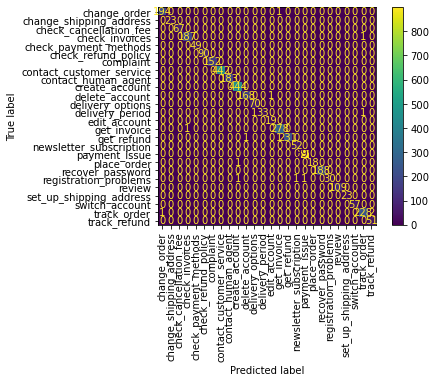

In [42]:
ConfusionMatrixDisplay.from_estimator(sgd, test["tokens"], test["intent"], xticks_rotation=90)

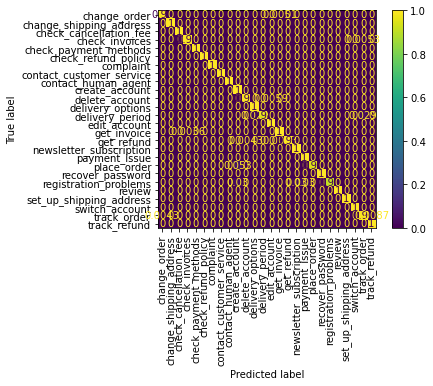

In [43]:
ConfusionMatrixDisplay.from_estimator(sgd, test["tokens"], test["intent"], xticks_rotation=90, normalize='true')

<h3> Error Analysis </h3>

In [44]:
err = test[(test['intent']=='change_order')&(predicted=='get_invoice')]
len(err)

1

In [45]:
err['utterance'].iloc[0]

'I want to change mypurchase, can you give me some information?'

In [46]:
err = test[(test['intent']=='check_invoices')&(predicted=='track_order')]
len(err)

1

In [47]:
err['utterance'].iloc[0]

'how do I check my bil?'

In [48]:
err = test[(test['intent']=='delete_account')&(predicted=='edit_account')]
len(err)

1

In [49]:
err['utterance'].iloc[0]

'I need help deleting my profile'

In [50]:
err = test[(test['intent']=='delivery_period')&(predicted=='track_order')]
len(err)

1

In [51]:
err['utterance'].iloc[0]

'when will my tickket arrive ?'

In [52]:
err = test[(test['intent']=='get_invoice')&(predicted=='check_invoices')]
len(err)

1

In [53]:
err['utterance'].iloc[0]

'how to obtainsome bills'

In [54]:
err = test[(test['intent']=='get_refund')&(predicted=='delete_account')]
len(err)

1

In [55]:
err['utterance'].iloc[0]

'how do I request areimbursement?'

In [56]:
err = test[(test['intent']=='place_order')&(predicted=='create_account')]
len(err)

1

In [57]:
err['utterance'].iloc[0]

'I need help making an ofder'

In [60]:
err = test[(test['intent']=='registration_problems')&(predicted=='create_account')]
len(err)

1

In [61]:
err['utterance'].iloc[0]

"I' trying to open an account but I can't"

In [62]:
err = test[(test['intent']=='registration_problems')&(predicted=='newsletter_subscription')]
len(err)

1

In [63]:
err['utterance'].iloc[0]

'There is a problem with the reggistration'

In [64]:
err = test[(test['intent']=='registration_problems')&(predicted=='payment_issue')]
len(err)

1

In [65]:
err['utterance'].iloc[0]

"I'm trying to regiter but I can't"

In [66]:
err = test[(test['intent']=='track_order')&(predicted=='change_order')]
len(err)

1

In [67]:
err['utterance'].iloc[0]

'I want to cherck my order, can you tell me where to do it?'

The pattern we see in all of these errors is that when a word is misspelled or is made up of
two words, the utterane is mislabeled.

<br>

<h3>Model Parameters</h3>

In [68]:
labels = sgd.named_steps['sgdclassifier'].classes_

In [69]:
coef = sgd.named_steps['sgdclassifier'].coef_
labels, coef

(array(['change_order', 'change_shipping_address',
        'check_cancellation_fee', 'check_invoices',
        'check_payment_methods', 'check_refund_policy', 'complaint',
        'contact_customer_service', 'contact_human_agent',
        'create_account', 'delete_account', 'delivery_options',
        'delivery_period', 'edit_account', 'get_invoice', 'get_refund',
        'newsletter_subscription', 'payment_issue', 'place_order',
        'recover_password', 'registration_problems', 'review',
        'set_up_shipping_address', 'switch_account', 'track_order',
        'track_refund'], dtype='<U24'),
 array([[ -0.96661984,  -3.79561331,  -0.68140799, ...,   0.        ,
           1.00934798,  -2.52515328],
        [  0.        ,  -3.67256505,  -2.46178024, ...,   0.        ,
          -0.19920431,   0.        ],
        [  0.        ,  -4.39540055,  -2.36639944, ...,   0.        ,
          -3.61150765,  -2.9081076 ],
        ...,
        [ -2.97748638,  -8.93898237,  -2.30068833, ...,   

In [70]:
coef.shape

(26, 367)

In [71]:
vocab = sgd.named_steps['countvectorizer'].get_feature_names_out()

In [72]:
coef[0,:].argmax()

180

In [74]:
coef[:,180]

array([ 14.08669566,   2.8428465 ,   0.        ,  -2.39255717,
        -3.12598353,   0.        ,   0.        ,   0.        ,
         0.        ,  -2.44936407, -15.29401515,   0.        ,
        -2.68224582,  13.58403722,  -2.08351989,   0.        ,
        -3.53268709,  -3.25360805,  -2.46199044,  -4.87798949,
         0.        ,   0.        ,  -3.01540094,   0.        ,
       -18.72682128,   0.        ])

In [76]:
vocab[180]

'modify'

the word 'modify' is the strongest indicator that it's an untterance about change_order

In [77]:
ranked = np.argsort(coef, axis=1)
for i, label in enumerate(labels):
    print(label)
    for j in concat([range(-1, -11, -1), range(10, 0, -1)]):
        print(f'  {vocab[ranked[i,j]]:15s} {coef[i, ranked[i,j]]:6.3f}')
    print()

change_order
  modify          14.087
  order           13.058
  purchase        11.774
  change          11.428
  ordered         10.127
  changing         9.789
  modifying        9.473
  it               9.055
  ell              8.559
  purchased        8.328
  of              -7.854
  address         -7.861
  help            -8.339
  do              -9.570
  another         -10.368
  the             -10.453
  account         -12.514
  is              -14.661
  track           -14.720
  profile         -15.856

change_shipping_address
  shipping        10.594
  address          8.978
  changes          4.305
  modify           2.843
  change           1.263
  to               0.712
  has              0.561
  how              0.406
  u                0.397
  changed          0.128
  another         -4.358
  email           -4.473
  order           -4.638
  the             -4.824
  it              -4.876
  have            -5.111
  profile         -5.419
  online          -5.457
  issu